Updated: 13/12/2023

This workbook demonstrates the spatial reconstruction of one linear mode, one quadratic mode and multiple modes simultaneously. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
from matplotlib.animation import FuncAnimation

l_max = 6
n_max = 6
t0 = {0:40., 1:18.5, 2:12., 3:8., 4:5.5, 5:3., 6:1.5, 7:0.}[n_max]

In [2]:
# TO DO: import data properly 

sim = qnmfits.SXS(ID=305, zero_time=(2,2))

/Users/christophermoore/miniconda3/envs/qnmfits/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [40]:
sim = qnmfits.SXS(ID=1427, zero_time=(2,2), transform='rotation')
sim.chif

Found the following files to load from the SXS catalog:
    SXS:BBH:1427v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1427v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|█████████████████████████████████████████████████████████████████████████████████| 72.2M/72.2M [00:02<00:00, 30.8MB/s]


array([-1.17687587e-06,  1.36994637e-06, -1.10714385e-01])

In [3]:
mapping = [(2,2,0,1)]

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

best_fit_linear = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

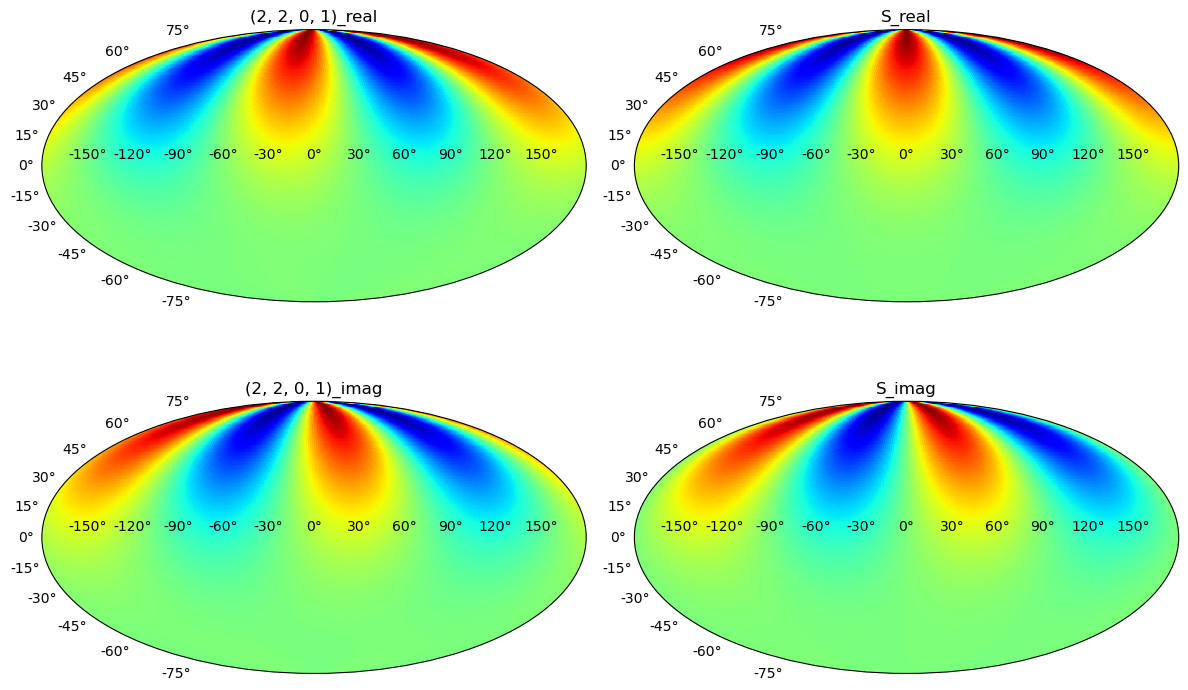

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, 
                        subplot_kw={'projection': 'mollweide'}, 
                        figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

map = mapping[0]

Lon, Lat = np.meshgrid(lon, lat)
F = mode_mapping(np.pi/2-Lat, Lon, best_fit_linear, map, l_max)
G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

axs[0,0].title.set_text(str(map)+'_real')
axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

axs[1,0].title.set_text(str(map)+'_imag')
axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

axs[0,1].title.set_text('S_real')
axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

axs[1,1].title.set_text('S_imag')
axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

## Calculate spatial mismatch over time

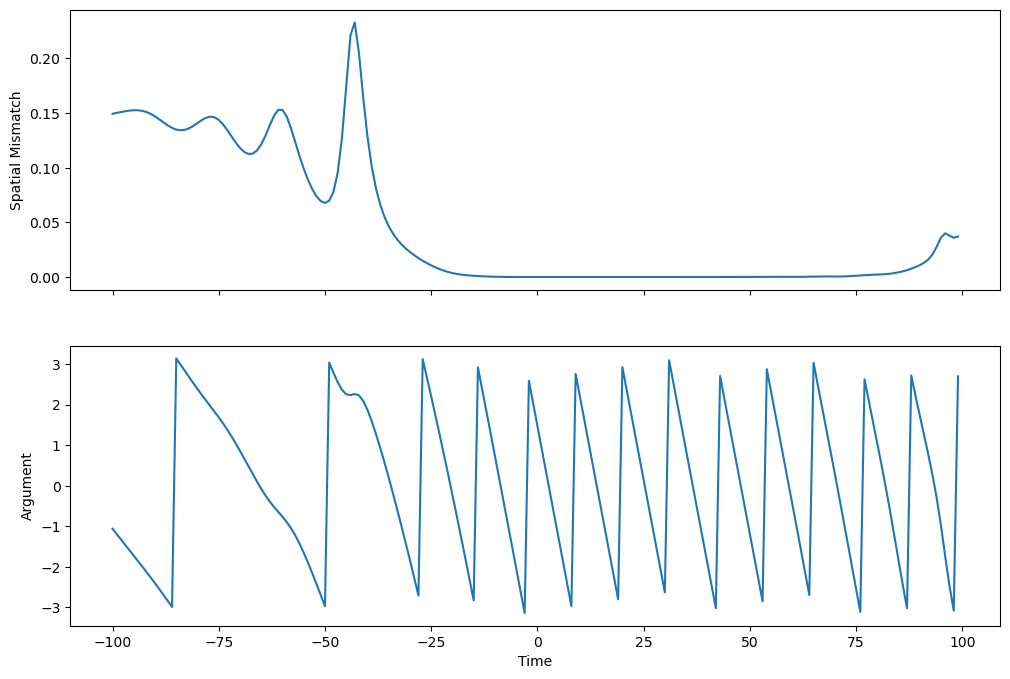

In [6]:
G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

time_array = np.arange(-100, 100, 1)
sm_list = []
arg_list = []

for time in time_array:
   best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                             sim.h, 
                                             modes=QNMs.copy(),
                                             Mf=sim.Mf,
                                             chif=sim.chif_mag,
                                             t0=time,
                                             mapping_modes=mapping,
                                             spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

   F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)

   sm, arg, _ = spatial_mismatch(F, G, num_points=100)
   sm_list.append(sm)
   arg_list.append(arg)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)
axs[0].plot(time_array, sm_list)
axs[1].plot(time_array, arg_list)

axs[0].set_ylabel('Spatial Mismatch')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Argument') 

plt.show()


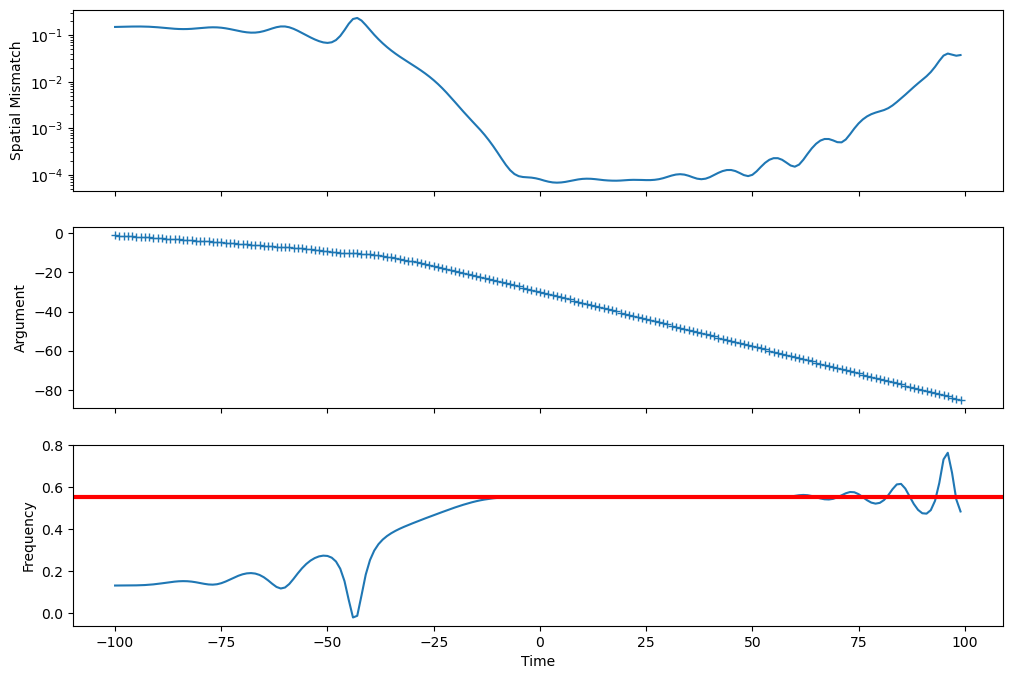

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)
axs[0].plot(time_array, sm_list)
axs[1].plot(time_array, np.unwrap(arg_list), '+')

from scipy.interpolate import UnivariateSpline
angle_v_time = UnivariateSpline(time_array, -np.unwrap(arg_list), k=4, s=0)
axs[2].plot(time_array, angle_v_time.derivative()(time_array))
axs[2].axhline(qnmfits.qnm.omega(2,2,0,1,sim.chif_mag, Mf=sim.Mf).real, color='r', ls='-', lw=3)

axs[0].set_yscale('log')

axs[0].set_ylabel('Spatial Mismatch')
axs[2].set_xlabel('Time')
axs[1].set_ylabel('Argument') 
axs[2].set_ylabel('Frequency') 

plt.show()

In [24]:
qnmfits.qnm.omega(2,2,0,1,sim.chif_mag, Mf=sim.Mf).real

0.5557819110480496

In [26]:
import numpy as np 

arg_list = [1,2,3,4,5,6,7,8,9,10,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]

diff_arg = np.diff(arg_list)

# Quadratic Test

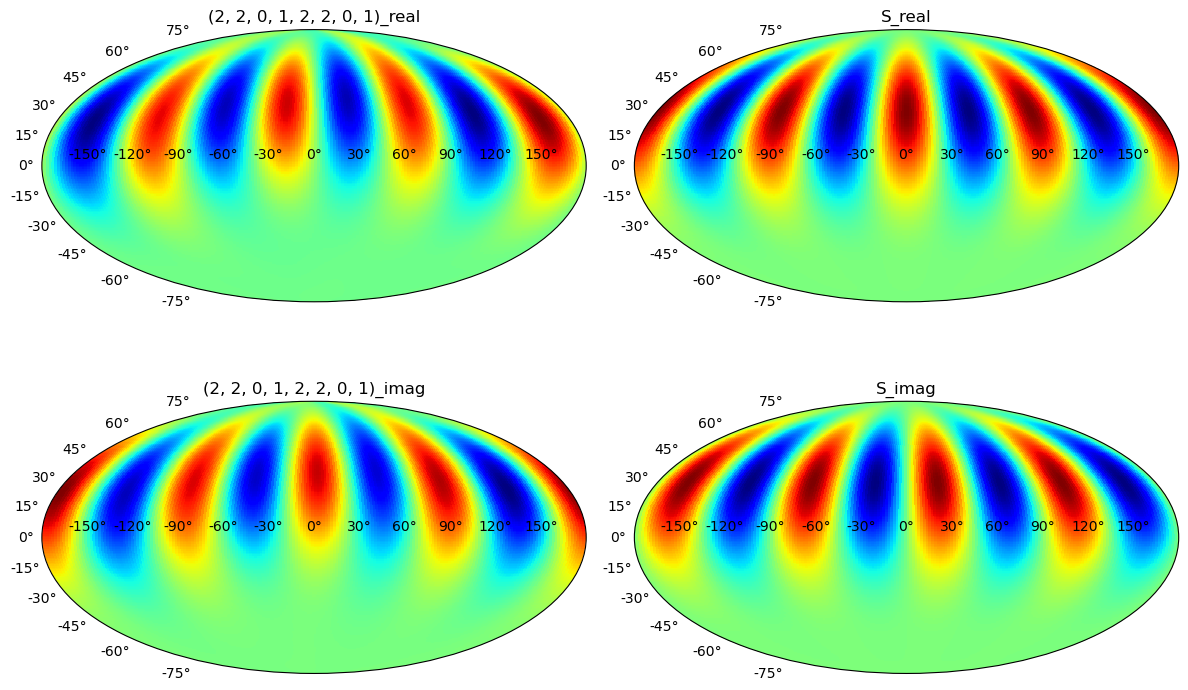

In [30]:
mapping = [(2,2,0,1,2,2,0,1)]

l_max = 4
n_max = 7

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)] + mapping 

best_fit_quad = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)
Lon, Lat = np.meshgrid(lon, lat)

#md_mapping = mode_mapping(np.pi/2-Lat, Lon, best_fit_quad, mapping[0], l_max)
#expected = spheroidal(np.pi/2-Lat, Lon, mapping[0], l_max, sim.chif_mag)

#qnm_viz.plot_mapping_projection(mapping[0], md_mapping, expected)

fig, axs = plt.subplots(nrows=2, ncols=2, 
                        subplot_kw={'projection': 'mollweide'}, 
                        figsize=(12,8))

Lon, Lat = np.meshgrid(lon, lat)
F = mode_mapping(np.pi/2-Lat, Lon, best_fit_quad, mapping[0], l_max)
G = spheroidal(np.pi/2-Lat, Lon, mapping[0], l_max, sim.chif_mag)

axs[0,0].title.set_text(str(mapping[0])+'_real')
axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

axs[1,0].title.set_text(str(mapping[0])+'_imag')
axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

axs[0,1].title.set_text('S_real')
axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

axs[1,1].title.set_text('S_imag')
axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

#### Spatial reconstruction of multiple modes

In [31]:
mapping = [(2,2,0,1), (3,3,0,1)] 

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)] 
                                                            
best_fit_multi = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

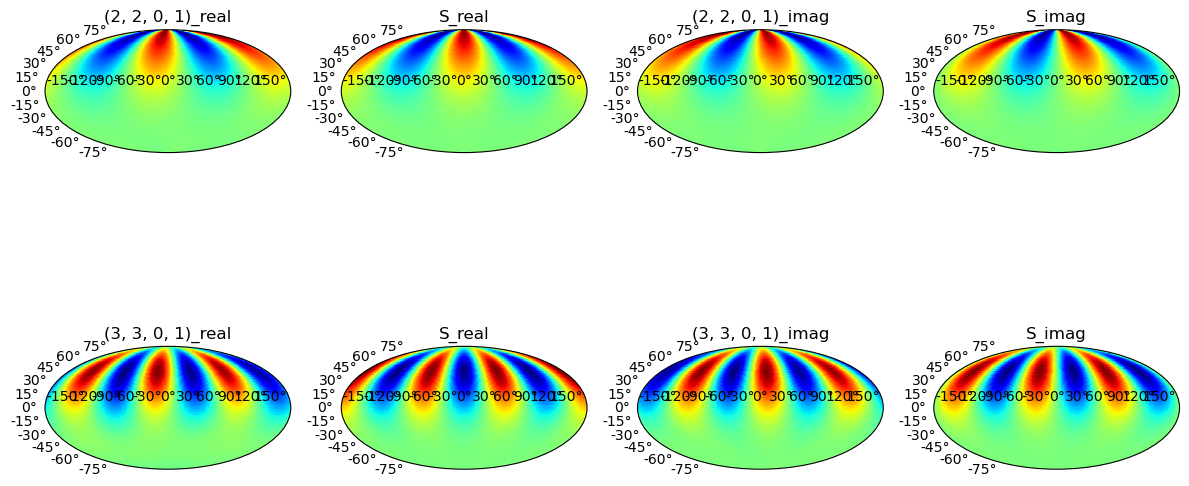

In [32]:

if len(mapping) == 1:
   nrows = 2
else:
   nrows = len(mapping)

fig, axs = plt.subplots(nrows=nrows, ncols=4, 
                  subplot_kw={'projection': 'mollweide'}, 
                  figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

Lon, Lat = np.meshgrid(lon, lat)

for i, mode in enumerate(mapping):
   F = mode_mapping(np.pi/2-Lat, Lon, best_fit_multi, mode, l_max)
   G = spheroidal(np.pi/2-Lat, Lon, mode, l_max, sim.chif_mag)

   axs[i, 0].title.set_text(str(mode)+'_real')
   axs[i, 0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

   axs[i, 1].title.set_text('S_real')
   axs[i, 1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

   axs[i, 2].title.set_text(str(mode)+'_imag')
   axs[i, 2].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

   axs[i, 3].title.set_text('S_imag')
   axs[i, 3].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

In [33]:
l_max = 3
n_max = 3

mapping = [(lam,mu,n,1) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)] 

QNMs = [(lam,mu,n,1) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)] 

best_fit_linear = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

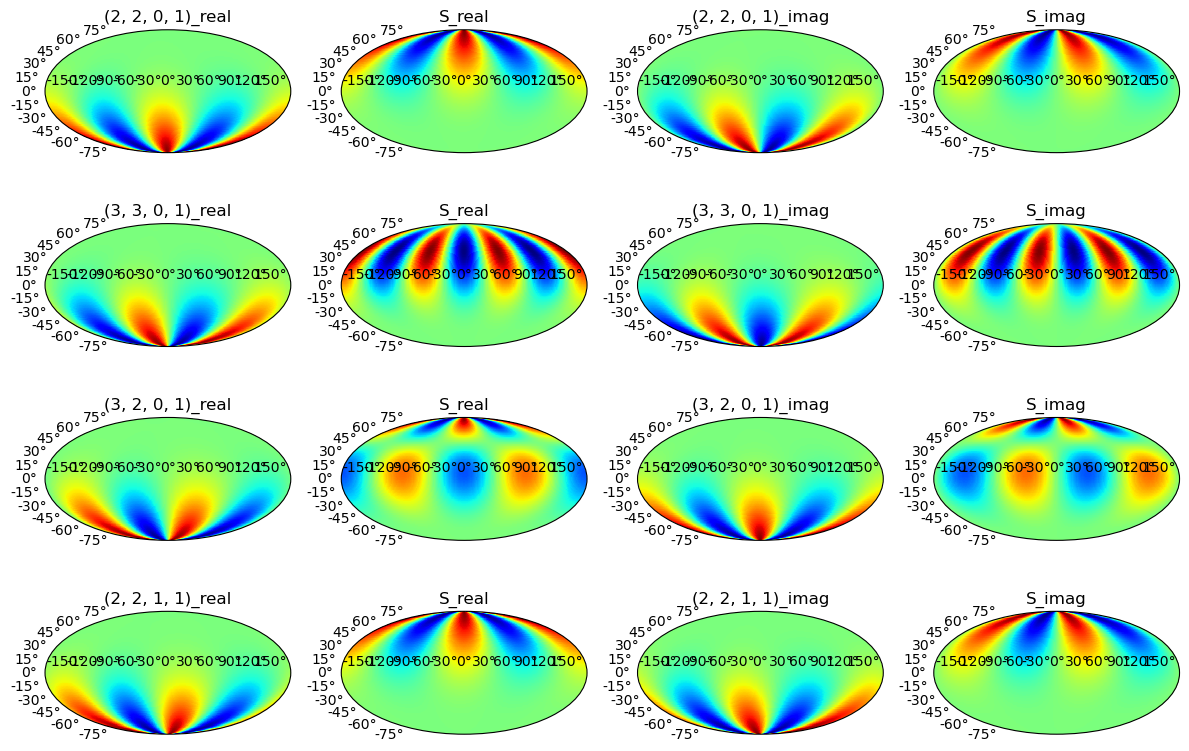

In [34]:
mapping_choice = [(2,2,0,1),(3,3,0,1),(3,2,0,1),(2,2,1,1)]

fig, axs = plt.subplots(nrows=(len(mapping_choice)), ncols=4, 
                  subplot_kw={'projection': 'mollweide'}, 
                  figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

Lon, Lat = np.meshgrid(lon, lat)

for i, mode in enumerate(mapping_choice):
   F = mode_mapping(np.pi/2-Lat, Lon, best_fit_linear, mode, l_max)
   G = spheroidal(np.pi/2-Lat, Lon, mode, l_max, sim.chif_mag)

   axs[i, 0].title.set_text(str(mode)+'_real')
   axs[i, 0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

   axs[i, 1].title.set_text('S_real')
   axs[i, 1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

   axs[i, 2].title.set_text(str(mode)+'_imag')
   axs[i, 2].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

   axs[i, 3].title.set_text('S_imag')
   axs[i, 3].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()